<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/LMS_EXP5_RockScissorPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Scissor Paper Node
2022-08-02  

This note follows modulab's exploration node 5 and including many copied code. Here, with image data made by myself, I made a rock-scissor-paper image classifier.
- train data : taken by webcam of my laptop, about 6 years old one. each 3 classes have about 100 images with varying background, alternate form, angle
- test data : given by modulab's course

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Resizing image file

As accuracy was ~66% in LMS node, I'll try to improve accuracy by
- using $56 \times 56$ pixel instead of $28 \times 28$. because I couldn't rclassify many image.
- using every dataset. I used only 100 photos while there are 155 photos prepared for scissors, because 'scissors' have alternate form so I took more photos

In [ ]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

	target_size=(56,56)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
image_dir_path = "./drive/MyDrive/colabdata/modulabs/lms_exp5"
#print(image_dir_path)
resize_images(image_dir_path+'/scissor/')
resize_images(image_dir_path+'/rock/')
resize_images(image_dir_path+'/paper/')

PIL 라이브러리 import 완료!
./drive/MyDrive/colabdata/modulabs/lms_exp5
155  images to be resized.
155  images resized.
103  images to be resized.
103  images resized.
105  images to be resized.
105  images resized.


## 2. load data
As I told already, there were 155 scissors, 103 rocks, 105 papers


In [ ]:
import numpy as np

def load_data(img_path, number_of_data=363):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=56
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    itot=0
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
        if idx>155:
            break
    itot+=idx
    idx=0
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
        if idx>103:
            break
    itot+=idx
    idx=0
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        if idx>105:
            break
    itot+=idx
    print("총 이미지 개수는", itot,"입니다.")
    return imgs, labels

image_dir_path = "./drive/MyDrive/colabdata/modulabs/lms_exp5"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

총 이미지 개수는 363 입니다.
x_train shape: (363, 56, 56, 3)
y_train shape: (363,)


라벨:  2
라벨:  2
라벨:  2
라벨:  2
라벨:  2


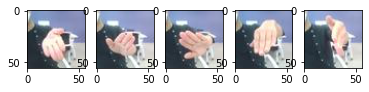

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(x_train[i])
    print('라벨: ', y_train[i])
plt.show()


# Initialize model from keras

input shape should be modified to (56, 56, 3).  
and I increased number of neuron by 2 times, just like pixel size.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(56,56,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 54, 54, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (

## compile model and fit.

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=2)

Epoch 1/2
12/12 [==============================] - 2s 121ms/step - loss: 0.1927 - accuracy: 0.9587
Epoch 2/2
12/12 [==============================] - 1s 118ms/step - loss: 0.2947 - accuracy: 0.9587


## resize test images and plot some images

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
총 이미지 개수는 300 입니다.
라벨:  2
라벨:  2
라벨:  2
라벨:  2
라벨:  2


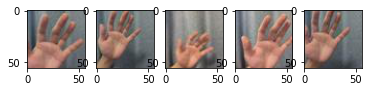

In [ ]:
image_dir_path2="./drive/MyDrive/colabdata/modulabs/lms_exp5/test"

resize_images(image_dir_path2+'/rock')
resize_images(image_dir_path2+'/scissor')
resize_images(image_dir_path2+'/paper')

x_test,y_test=load_data(image_dir_path2,300)

import matplotlib.pyplot as plt

fig, ax=plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(x_test[i])
    print('라벨: ', y_test[i])
plt.show()


### get accuracy and loss by test data

In [ ]:
test_loss, test_acc = model.evaluate(x_test,y_test,verbose=2)
print('test_loss: {} '.format(test_loss))
print('test_acc: {}'.format(test_acc))


10/10 - 0s - loss: 0.0452 - accuracy: 0.9733 - 493ms/epoch - 49ms/step
test_loss: 0.045199014246463776 
test_acc: 0.9733333587646484


# Conclusion
 maybe I had tried to add layer if accuracy is not high enough. but it is accurate enough as I expected. It was so difficult to choose what is good training dataset. And there were another issue; can I see the test data-set?  
 Before I take pictures of my hand, I had to decide many things. For example; what is scissor? Sometimes I used 4th and 5th finger as scissor. Some of my friend didn't admit is as a scissor. And viewpoint also matters. Sometimes one sees other's hand at backward.  
 I included major two variation of scissor only but included backward angle.   
  Cosidering these things, my hand in image became too smaller (in propotion). When I rescaled it to 28 by 28 pixels, it was hard to distinguish the class. I felt it will be wrong but still it showed accuracy over 60%. It was quiet accurate then I expected. I was told before about the accuracy from facilitator Kim. But I was convinced finally after I plotted given test image. It was similar to mine!  
  Maybe I will determine effect of this luck by different image files, taken by someone else (except me and test data)